# Text Mining Project on Korea Herald

# Data Preparation

## Load Data

In [103]:
pd.set_option('display.max_colwidth', -1)

In [1]:
import json
import pandas as pd
import gzip
import numpy as np

data_path = '../data/koreaherald_1517_#.json.gz'

df_data = pd.DataFrame()

for i in range(8):
  p = data_path.replace('#',str(i))
  with gzip.open(p,'rb') as f:
    data = pd.DataFrame.from_dict(json.load(f))
  df_data = df_data.append(data,ignore_index=True)

# clean up column names
df_data = df_data.rename(columns={" author": "author",
                        " time": "time",
                        " description": "description",
                        " body": "body",
                        " section": "section",
                       })
# preview data
print('Number of docs: {}'.format(df_data.shape[0]))
df_data.dtypes

Number of docs: 23769


title          object
author         object
time           object
description    object
body           object
section        object
dtype: object

## Pre-Processing

Here we apply:
- tokenisation
- lemmatisation
- normalisation

(optional) Bigrams

In [2]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
whitelist = {'US':'United States'}

def tokenise_pipeline(doc):
  for k,v in whitelist:
    doc = doc.replace(k,v)
  doc = doc.lower()  # Convert to lowercase.
  tokens = tokenizer.tokenize(doc) # split into words
  # TODO: remove stopwords
  tokens = [token for token in tokens if not token.isnumeric()] # remove numbers
  tokens = [token for token in tokens if token not in stop_words]
  tokens = [token for token in tokens if len(token) > 2] # remove words of only 1 letter
  tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatisation
  return tokens

In [3]:
df_data['body_tokenised'] = df_data['body'].apply(tokenise_pipeline)
df_data['title_tokenised'] = df_data['title'].apply(tokenise_pipeline)

In [4]:
from gensim.models import Phrases

bigrams = Phrases(df_data['body_tokenised'].values, min_count=20) # keeps only phrases that appear >= 20 times in corpus.

def add_bigrams(doc):
  for token in bigrams[doc]:
    if '_' in token:
      doc.append(token)
  return doc

df_data['body_tokenised'] = df_data['body_tokenised'].apply(add_bigrams)

In [5]:
from gensim.models import Phrases

title_bigrams = Phrases(df_data['title_tokenised'].values, min_count=20) # keeps only phrases that appear >= 20 times in corpus.

def add_bigrams(doc):
  for token in title_bigrams[doc]:
    if '_' in token:
      doc.append(token)
  return doc

df_data['title_tokenised'] = df_data['title_tokenised'].apply(add_bigrams)

In [6]:
from gensim.corpora import Dictionary

dictionary = Dictionary(df_data['body_tokenised'].values)
dictionary.filter_extremes(no_below=20, no_above=0.5) # filter words that occur in less than 20 docs or more than 50% docs

print('Number of unique tokens: {}'.format(len(dictionary)))
print('Number of documents: {}'.format(len(df_data['body_tokenised'].values)))

Number of unique tokens: 16614
Number of documents: 23769


## Vectorization

In [7]:
# BOW vectorisation
# TFIDF vectorisation
from gensim.models import TfidfModel

corpus = [dictionary.doc2bow(doc) for doc in df_data['body_tokenised']]
tfidf = TfidfModel(corpus)
df_data['body_bow'] = df_data['body_tokenised'].apply(dictionary.doc2bow)
df_data['body_tfidf'] = df_data['body_bow'].apply(lambda doc : tfidf[doc])

## Group By Year

In [8]:
import copy

df_2015 = copy.deepcopy(df_data[df_data['time'].str.contains('2015')])
df_2016 = copy.deepcopy(df_data[df_data['time'].str.contains('2016')])
df_2017 = copy.deepcopy(df_data[df_data['time'].str.contains('2017')])

# 2015 Analysis

## Get n_topics by evaluating Coherence

In [8]:
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.models import LdaModel
# import seaborn as sns
# from tqdm import tqdm

# temp = dictionary[0] # to 'load' dictionary
# id2word = dictionary.id2token

# # parameters
# feature = 'body_bow' # lda uses bow
# corpus = df_2015[feature].values

# results = []

# for i in tqdm(range(10,31)):
#   model = LdaModel(
#     corpus = corpus,
#     id2word = id2word,
#     chunksize = 2000,
#     alpha = 'auto',
#     eta = 'auto',
#     iterations = 400,
#     num_topics = i,
#     passes = 20,
#     eval_every = None
#     )
#   cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
#   coherence = cm.get_coherence()
#   results.append([i,coherence])
  
  
# best_score = max([i[1] for i in results])
# best_num_topics = [i[0] for i in results if i[1] == best_score][0]
# sns.lineplot(x=[i[0] for i in results], y=[i[1] for i in results])
# print('Best Coherence Score: {}, Number of Topics: {}'.format(best_score, best_num_topics))

100%|██████████| 21/21 [59:17<00:00, 169.39s/it] 


Best Coherence Score: -1.3090987513876662, Number of Topics: 12


## LDA

In [9]:
from gensim.models import LdaModel

temp = dictionary[0] # to 'load' dictionary
id2word = dictionary.id2token

# parameters
feature = 'body_bow' # lda uses bow
corpus = df_2015[feature].values
# num_topics = best_num_topics
num_topics = 12

model_2015 = LdaModel(
  corpus = corpus,
  id2word = id2word,
  chunksize = 2000,
  alpha = 'auto',
  eta = 'auto',
  iterations = 400,
  num_topics = num_topics,
  passes = 20,
  eval_every = None
  )

### LDA Visualisation

In [10]:
import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model_2015, corpus, dictionary)

# The larger the bubble, the more prevalent is that topic.
# A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
# A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.026294 -0.019311       1        1  14.974554
6     -0.137128 -0.082621       2        1  11.355777
10     0.081553  0.107690       3        1  10.147457
0     -0.073373  0.200258       4        1   9.775513
1     -0.186132 -0.066573       5        1   9.012900
11    -0.088314 -0.076501       6        1   8.895386
4      0.194743  0.054727       7        1   7.660823
9      0.190925 -0.028080       8        1   6.429377
8     -0.135003 -0.028617       9        1   6.263202
5      0.007041 -0.196996      10        1   5.780384
2     -0.084780  0.206273      11        1   5.140346
3      0.204175 -0.070249      12        1   4.564280, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
329    Default  17290.000000         north  17290.000000  30.0000  30.0000
113    Default   5702.000000       percent   5702.000000  29.0000  29.0000
69     Default   5199.000000         japan   5199.000000  28.0000  28.0000
740    Default   6224.000000         party   6224.000000  27.0000  27.0000
341    Default   8575.000000          park   8575.000000  26.0000  26.0000
332    Default   4404.000000       nuclear   4404.000000  25.0000  25.0000
237    Default   3520.000000       defense   3520.000000  24.0000  24.0000
718    Default   4326.000000      military   4326.000000  23.0000  23.0000
24     Default   5689.000000         china   5689.000000  22.0000  22.0000
911    Default   6752.000000           kim   6752.000000  21.0000  21.0000
2967   Default   2104.000000        police   2104.000000  20.0000  20.0000
354    Default   4923.000000     president   4923.000000  19.0000  19.0000
1719   Default   2116.000000      japanese   2116.000000  18.0000  18.0000
894    Default   8018.000000    government   8018.000000  17.0000  17.0000
365    Default   3220.000000     pyongyang   3220.000000  16.0000  16.0000
16328  Default   1677.000000          mers   1677.000000  15.0000  15.0000
132    Default   2338.000000        school   2338.000000  14.0000  14.0000
153    Default   2225.000000       student   2225.000000  13.0000  13.0000
317    Default   2550.000000       missile   2550.000000  12.0000  12.0000
1972   Default   1784.000000        health   1784.000000  11.0000  11.0000
2360   Default   1399.000000       patient   1399.000000  10.0000  10.0000
719    Default   4499.000000      minister   4499.000000   9.0000   9.0000
715    Default   3452.000000       meeting   3452.000000   8.0000   8.0000
2335   Default   1342.000000       disease   1342.000000   7.0000   7.0000
34     Default   2225.000000     education   2225.000000   6.0000   6.0000
2184   Default   1381.000000          bill   1381.000000   5.0000   5.0000
6839   Default   1469.000000           abe   1469.000000   4.0000   4.0000
2311   Default   2528.000000         woman   2528.000000   3.0000   3.0000
563    Default   3494.000000          talk   3494.000000   2.0000   2.0000
1485   Default   1381.000000      hospital   1381.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
13951  Topic12    100.258202  sierra_leone    101.173012   3.0778  -6.6507
16386  Topic12     98.169609   quarantined     99.084412   3.0776  -6.6717
5302   Topic12    290.175629     diagnosed    293.449524   3.0757  -5.5879
15624  Topic12    224.095596         ebola    227.641754   3.0712  -5.8463
1537   Topic12    420.713409        doctor    430.849243   3.0631  -5.2165
6338   Topic12    155.464050         nurse    157.915939   3.0713  -6.2120
3292   Topic12   1179.811646       medical   1249.142578   3.0298  -4.1853
1485   Topic12   1258.745972      hospital   1381.548462   2.9938  -4.1206
5704   Topic12    483.056854   middle_east    574.859070   2.9129  -5.0783
1972   Topic12   1334.220337        health   1784.5

In [149]:
topics_2015 = pd.DataFrame({'topic':[i for i in range(12)]})
topics_2015['keywords'] = topics_2015.topic.apply(lambda x: sorted(model_2015.show_topic(x, 20),key=lambda x: x[1], reverse=True))
topics_2015.to_pickle('topics_2015.pkl')
topics_2015

,topic,keywords
0,0,"[(party, 0.023004688), (park, 0.020934923), (lee, 0.014710705), (president, 0.013309595), (kim, 0.009731325), (former, 0.009545535), (sung, 0.008222587), (opposition, 0.007933193), (election, 0.0077036507), (minister, 0.007353098), (presidential, 0.007179816), (moon, 0.0071514766), (saenuri, 0.0067606647), (political, 0.006755527), (new, 0.0064623565), (rep, 0.0064466605), (ruling, 0.006134111), (lawmaker, 0.0056571327), (prime, 0.0053346413), (president_park, 0.0053209774)]"
1,1,"[(park, 0.022472357), (meeting, 0.014187733), (china, 0.014152635), (president, 0.012893844), (foreign, 0.012686718), (minister, 0.012183935), (two, 0.011285768), (talk, 0.011164676), (visit, 0.010504786), (cooperation, 0.009806723), (official, 0.009163013), (summit, 0.008470482), (south_korean, 0.0076493067), (bilateral, 0.0074954284), (president_park, 0.0073251505), (country, 0.007322238), (hye, 0.0066263913), (geun, 0.006578917), (geun_hye, 0.006552366), (ministry, 0.0064509837)]"
2,2,"[(government, 0.022931311), (bill, 0.015812663), (party, 0.014785837), (public, 0.010958368), (assembly, 0.010630234), (reform, 0.009983241), (national, 0.009717848), (would, 0.008795793), (park, 0.007860149), (plan, 0.0077648037), (pension, 0.007610699), (committee, 0.007078214), (national_assembly, 0.00689653), (opposition, 0.0066271797), (lawmaker, 0.006600515), (saenuri, 0.0062419116), (ruling, 0.005927681), (meeting, 0.0049699317), (session, 0.0047810925), (parliamentary, 0.00476373)]"
3,3,"[(mers, 0.021626022), (patient, 0.018045481), (disease, 0.017302645), (health, 0.01720905), (hospital, 0.016235566), (medical, 0.015217455), (case, 0.011621722), (ministry, 0.011368378), (people, 0.010018286), (virus, 0.009317075), (outbreak, 0.009300108), (country, 0.008194114), (first, 0.008136989), (day, 0.00743851), (confirmed, 0.0074215652), (middle, 0.0071602394), (respiratory, 0.0067214724), (reported, 0.006654807), (may, 0.006431566), (middle_east, 0.006230567)]"
4,4,"[(percent, 0.037723962), (child, 0.011903506), (number, 0.010348392), (worker, 0.009835261), (according, 0.008773991), (woman, 0.008574037), (last, 0.0076157143), (job, 0.007209311), (rate, 0.0070889993), (last_year, 0.0065988335), (showed, 0.0065472596), (million, 0.0064580715), (labor, 0.005923012), (government, 0.0058314106), (report, 0.0054925936), (time, 0.005363527), (data, 0.0051833475), (wage, 0.0050805877), (people, 0.0050199535), (work, 0.004625201)]"
5,5,"[(defense, 0.0270829), (military, 0.025704227), (force, 0.011438785), (official, 0.008193393), (ministry, 0.008020396), (air, 0.008007101), (missile, 0.007420266), (south_korean, 0.006806241), (submarine, 0.0059197336), (joint, 0.00568712), (navy, 0.005637969), (two, 0.00553427), (troop, 0.005233692), (sea, 0.005123518), (operation, 0.005094195), (plan, 0.0049772966), (army, 0.004937387), (exercise, 0.004915406), (country, 0.0046160095), (defense_ministry, 0.004527088)]"
6,6,"[(north, 0.040910687), (nuclear, 0.020242183), (china, 0.014803447), (missile, 0.009438721), (pyongyang, 0.008640812), (state, 0.00834108), (security, 0.007393212), (would, 0.007352189), (test, 0.005916069), (washington, 0.0052490947), (issue, 0.0052044117), (snited, 0.0049785036), (right, 0.0048199873), (threat, 0.0047698636), (party, 0.004752492), (could, 0.0046913465), (international, 0.004687748), (talk, 0.0045216107), (long, 0.00438373), (snited_state, 0.004274297)]"
7,7,"[(country, 0.01248819), (world, 0.0059831883), (development, 0.0058895405), (trade, 0.0055872463), (government, 0.005453033), (company, 0.005244035), (city, 0.0052429666), (project, 0.0050124647), (international, 0.00475202), (economic, 0.0046164575), (new, 0.004464806), (business, 0.004446621), (billion, 0.0040488094), (market, 0.003987323), (people, 0.0037102227), (economy, 0.003696364), (global, 0.00360464), (energy, 0.0035473974), (industry, 0.0033372734), (million, 0.0032013631)]"
8,8,"[(japan, 0.040976774), (japanese, 0.018836511), (abe, 0.013803036), (issue, 0.012964607

### Assign Topics to Docs

In [11]:
def argmax(ls):
  return max(ls, key = lambda item: item[1])


df_2015['topic'] = df_2015[feature].apply(lambda x : argmax(model_2015.get_document_topics(x))[0])
df_2015['topic_confidence'] = df_2015[feature].apply(lambda x : argmax(model_2015.get_document_topics(x))[1])

## Cluster Analysis

### get only documents with topic_confidence >= t = 0.85

In [47]:
df_2015 = pd.read_pickle('df_2015.pkl')

In [48]:
df_anal = df_2015[df_2015['topic_confidence'] >= 0.85]

## Metric 1: Number of Documents

In [49]:
df_anal.topic.value_counts()

3     79
4     73
7     66
6     66
8     58
11    43
0     37
1     19
10    13
5     10
9      2
2      2
Name: topic, dtype: int64

## Metric 2: Duration of Reporting

In [56]:
from datetime import datetime

report_duration = pd.DataFrame(columns=['topic','duration'])

for i in df_anal.topic.unique():
  df = df_anal[df_anal['topic'] == i]
  max_t = datetime.strptime(df.time.max(), "%Y-%m-%d %H:%M:%S").date()
  min_t = datetime.strptime(df.time.min(), "%Y-%m-%d %H:%M:%S").date()
  report_duration = report_duration.append(pd.DataFrame({'topic': i, 'duration': (max_t - min_t)}, index=[i]))
  
report_duration.sort_values('duration',ascending=False)

,topic,duration
6,6,363 days
4,4,360 days
8,8,358 days
7,7,353 days
0,0,348 days
10,10,322 days
5,5,299 days
1,1,287 days
11,11,270 days
3,3,183 days


## Metric 3: Entity Relations

In [63]:
import spacy
nlp = spacy.load("en")

# Labels: ORG, LOC, PERSON
def get_entities(txt, label):
  #the NER model only takes in unicode so convert str to unicode
  doc = nlp(txt)
  
  #doc now contains all the entities identified
  NER_list = [((ent.text).encode("utf-8"),ent.label_) for ent in doc.ents]

  #this line is to remove duplicate entities
  NER_list = list(dict.fromkeys(NER_list))

  #converting list of tuples to list of lists for easier manipulation later
  NER_list_final = [list(entity) for entity in NER_list]

  #Filtering for the entity labels that we are interested in.
  entities = [entity[0] for entity in NER_list_final if entity[1] == label]
  
  return entities

df_anal['ORGS'] = df_anal['body'].apply(lambda x: get_entities(x, 'ORG'))
df_anal['LOC'] = df_anal['body'].apply(lambda x: get_entities(x, 'LOC'))
df_anal['PERSON'] = df_anal['body'].apply(lambda x: get_entities(x, 'PERSON'))

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [64]:
entity_counts = pd.DataFrame(columns=['topic','n_org','n_loc','n_person'])

for i in df_anal.topic.unique():
  df = df_anal[df_anal['topic'] == i]
  n_orgs = len(set([x for ls in df['ORGS'] for x in ls]))
  n_loc = len(set([x for ls in df['LOC'] for x in ls]))        
  n_person = len(set([x for ls in df['PERSON'] for x in ls]))
  entity_counts = entity_counts.append(pd.DataFrame({'topic': i,'n_org': n_orgs,'n_loc': n_loc,'n_person': n_person,'n_total': n_orgs + n_loc + n_person}, index=[i]))
  
entity_counts.sort_values('n_total',ascending=False)

,n_loc,n_org,n_person,n_total,topic
7,13,21,20,54.0,7
6,15,13,24,52.0,6
0,7,5,23,35.0,0
3,10,14,11,35.0,3
8,8,7,19,34.0,8
11,10,7,16,33.0,11
4,9,9,14,32.0,4
1,5,3,9,17.0,1
10,4,6,5,15.0,10
5,2,2,7,11.0,5


In [65]:
results_2015 = pd.DataFrame()
results_2015['topic'] = df_anal.topic.value_counts().index
results_2015['doc_counts'] = df_anal.topic.value_counts().values
results_2015 = pd.merge(results_2015.astype('object'), report_duration.astype('object'), on='topic')
results_2015 = pd.merge(results_2015.astype('object'), entity_counts.astype('object'), on='topic')

results_2015

,topic,doc_counts,duration,n_loc,n_org,n_person,n_total
0,3,79,183 days 00:00:00,10,14,11,35
1,4,73,360 days 00:00:00,9,9,14,32
2,7,66,353 days 00:00:00,13,21,20,54
3,6,66,363 days 00:00:00,15,13,24,52
4,8,58,358 days 00:00:00,8,7,19,34
5,11,43,270 days 00:00:00,10,7,16,33
6,0,37,348 days 00:00:00,7,5,23,35
7,1,19,287 days 00:00:00,5,3,9,17
8,10,13,322 days 00:00:00,4,6,5,15
9,5,10,299 days 00:00:00,2,2,7,11


In [137]:
# topic ranking for 2015
topic_ids_2015 = [3, 4, 6, 7, 8, 0, 11, 1, 10, 5]

topics_2015 = pd.DataFrame({'topic':[i for i in topic_ids_2015]})
topics_2015['keywords_prob'] = topics_2015.topic.apply(lambda x: sorted(model_2015.show_topic(x, 20),key=lambda x: x[1], reverse=True))
topics_2015['keywords'] = topics_2015['keywords_prob'].apply(lambda x: [i[0] for i in x])

# topics_2015.to_csv('selected_topics_2015.csv',index=False)
topics_2015[['topic','keywords']]

,topic,keywords
0,3,"[mers, patient, disease, health, hospital, medical, case, ministry, people, virus, outbreak, country, first, day, confirmed, middle, respiratory, reported, may, middle_east]"
1,4,"[percent, child, number, worker, according, woman, last, job, rate, last_year, showed, million, labor, government, report, time, data, wage, people, work]"
2,6,"[north, nuclear, china, missile, pyongyang, state, security, would, test, washington, issue, snited, right, threat, party, could, international, talk, long, snited_state]"
3,7,"[country, world, development, trade, government, company, city, project, international, economic, new, business, billion, market, people, economy, global, energy, industry, million]"
4,8,"[japan, japanese, abe, issue, tokyo, war, woman, history, world, minister, victim, wartime, statement, sexual, apology, relation, prime, country, historical, world_war]"
5,0,"[party, park, lee, president, kim, former, sung, opposition, election, minister, presidential, moon, saenuri, political, new, rep, ruling, lawmaker, prime, president_park]"
6,11,"[north, kim, pyongyang, inter, two, south_korean, border, inter_korean, official, jong, leader, war, government, leader_kim, military, family, talk, ministry, day, unification]"
7,1,"[park, meeting, china, president, foreign, minister, two, talk, visit, cooperation, official, summit, south_korean, bilateral, president_park, country, hye, geun, geun_hye, ministry]"
8,10,"[school, student, education, court, government, law, ministry, right, case, textbook, one, state, kim, high, would, history, university, sniversity, official, teacher]"
9,5,"[defense, military, force, official, ministry, air, missile, south_korean, submarine, joint, navy, two, troop, sea, operation, plan, army, exercise, country, defense_ministry]"


# 2016 Analysis

## Get n_topics by evaluating Coherence

100%|██████████| 21/21 [1:04:10<00:00, 183.34s/it]


Best Coherence Score: -1.317349553342286, Number of Topics: 12


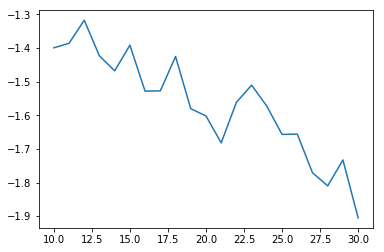

In [22]:
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.models import LdaModel
# import seaborn as sns
# from tqdm import tqdm

# temp = dictionary[0] # to 'load' dictionary
# id2word = dictionary.id2token

# # parameters
# feature = 'body_bow' # lda uses bow
# corpus = df_2016[feature].values

# results = []

# for i in tqdm(range(10,31)):
#   model = LdaModel(
#     corpus = corpus,
#     id2word = id2word,
#     chunksize = 2000,
#     alpha = 'auto',
#     eta = 'auto',
#     iterations = 400,
#     num_topics = i,
#     passes = 20,
#     eval_every = None
#     )
#   cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
#   coherence = cm.get_coherence()
#   results.append([i,coherence])
  
# best_score = max([i[1] for i in results])
# best_num_topics = [i[0] for i in results if i[1] == best_score][0]
# sns.lineplot(x=[i[0] for i in results], y=[i[1] for i in results])
# print('Best Coherence Score: {}, Number of Topics: {}'.format(best_score, best_num_topics))

## LDA

In [17]:
from gensim.models import LdaModel

temp = dictionary[0] # to 'load' dictionary
id2word = dictionary.id2token

# parameters
feature = 'body_bow' # lda uses bow
corpus = df_2016[feature].values
# num_topics = best_num_topics
num_topics = 12

model_2016 = LdaModel(
  corpus = corpus,
  id2word = id2word,
  chunksize = 2000,
  alpha = 'auto',
  eta = 'auto',
  iterations = 400,
  num_topics = num_topics,
  passes = 20,
  eval_every = None
  )

### LDA Visualisation

In [18]:
import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model_2016, corpus, dictionary)

# The larger the bubble, the more prevalent is that topic.
# A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
# A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.038945  0.224007       1        1  14.894046
7      0.031067  0.166442       2        1  13.831355
2     -0.018971  0.119951       3        1  11.683764
8      0.200883 -0.056903       4        1   9.662674
5     -0.157549 -0.035599       5        1   9.040518
3      0.098688 -0.113817       6        1   8.713591
4     -0.070723 -0.101843       7        1   8.419481
1     -0.061816  0.077508       8        1   5.574544
0     -0.120049 -0.181783       9        1   5.055354
9      0.197794  0.017822      10        1   4.509366
10     0.084408 -0.156656      11        1   4.350085
11    -0.222677  0.040871      12        1   4.265218, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
329    Default  22423.000000           north  22423.000000  30.0000  30.0000
740    Default  11921.000000           party  11921.000000  29.0000  29.0000
341    Default   9750.000000            park   9750.000000  28.0000  28.0000
113    Default   6187.000000         percent   6187.000000  27.0000  27.0000
332    Default   9426.000000         nuclear   9426.000000  26.0000  26.0000
317    Default   6025.000000         missile   6025.000000  25.0000  25.0000
354    Default   6794.000000       president   6794.000000  24.0000  24.0000
2967   Default   2729.000000          police   2729.000000  23.0000  23.0000
2184   Default   1888.000000            bill   1888.000000  22.0000  22.0000
782    Default   3778.000000        sanction   3778.000000  21.0000  21.0000
69     Default   2801.000000           japan   2801.000000  20.0000  20.0000
237    Default   3586.000000         defense   3586.000000  19.0000  19.0000
207    Default   2520.000000            choi   2520.000000  18.0000  18.0000
5854   Default   2644.000000         saenuri   2644.000000  17.0000  17.0000
406    Default   5772.000000            test   5772.000000  16.0000  16.0000
132    Default   2287.000000          school   2287.000000  15.0000  15.0000
365    Default   4092.000000       pyongyang   4092.000000  14.0000  14.0000
255    Default   2415.000000        election   2415.000000  13.0000  13.0000
894    Default   7251.000000      government   7251.000000  12.0000  12.0000
718    Default   4344.000000        military   4344.000000  11.0000  11.0000
931    Default   3305.000000      opposition   3305.000000  10.0000  10.0000
451    Default   2105.000000           court   2105.000000   9.0000   9.0000
209    Default   2473.000000            city   2473.000000   8.0000   8.0000
153    Default   2061.000000         student   2061.000000   7.0000   7.0000
948    Default   2458.000000             rep   2458.000000   6.0000   6.0000
100    Default   5873.000000        ministry   5873.000000   5.0000   5.0000
3912   Default   2215.000000           child   2215.000000   4.0000   4.0000
358    Default   2881.000000    presidential   2881.000000   3.0000   3.0000
440    Default   2109.000000        assembly   2109.000000   2.0000   2.0000
357    Default   2653.000000  president_park   2653.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
1924   Topic12    266.794159          animal    339.552551   2.9135  -5.6546
118    Topic12    887.626465        province   1522.878906   2.6149  -4.4525
10362  Topic12    210.213608             bus    261.990021   2.9345  -5.8930
2449   Topic12    197.989899            wave    245.900864   2.9380  -5.9529
888    Topic12    334.205536          flight    490.658875   2.7707  -5.4293
1276   Topic12    427.980469         airport    693.145630   2.6725  -5.1820
2979   Topic12    270.592834             car    388.973633   2.7918  -5.6405
6323   Topic12    233.588394          subway    327.938446   2.8154  -5.7875
1516   Topic12    446.186310          safety

In [133]:
topics_2016 = pd.DataFrame({'topic':[i for i in range(12)]})
topics_2016['keywords'] = topics_2016.topic.apply(lambda x: sorted(model_2016.show_topic(x, 20),key=lambda x: x[1], reverse=True))
topics_2016.to_pickle('topics_2016.pkl')
topics_2016

,topic,keywords
0,0,"[(police, 0.026326606), (case, 0.011607173), (prosecutor, 0.01075611), (court, 0.009571413), (victim, 0.008572294), (charge, 0.00826571), (crime, 0.007916928), (old, 0.006728971), (man, 0.0066580046), (year_old, 0.0066465405), (district, 0.0062674354), (investigation, 0.006238106), (found, 0.006078361), (two, 0.0053926366), (suspect, 0.0051468), (according, 0.005131725), (month, 0.0050580082), (agency, 0.0047336393), (office, 0.004678169), (last, 0.004586224)]"
1,1,"[(japan, 0.018269772), (military, 0.010629202), (japanese, 0.010277815), (victim, 0.009971526), (south_korean, 0.009618279), (war, 0.008594713), (woman, 0.008593946), (two, 0.0077895075), (government, 0.007515656), (ministry, 0.006837031), (deal, 0.0063782153), (chinese, 0.0061580376), (tokyo, 0.0058261887), (soldier, 0.005640277), (issue, 0.0054290225), (official, 0.0053571463), (country, 0.005115557), (sexual, 0.0050308383), (agreement, 0.004920582), (island, 0.0041043833)]"
2,2,"[(country, 0.013437444), (economic, 0.006803508), (international, 0.0062800134), (cooperation, 0.006025098), (foreign, 0.00598794), (world, 0.0058575557), (two, 0.0054390477), (development, 0.0053091086), (trade, 0.005140604), (minister, 0.0048180614), (new, 0.004794649), (government, 0.0047051827), (last, 0.0045998213), (economy, 0.0040658093), (business, 0.003868409), (nation, 0.0037584824), (program, 0.0037360748), (effort, 0.003664616), (global, 0.0036513004), (project, 0.003544811)]"
3,3,"[(park, 0.043991223), (president, 0.027614208), (choi, 0.015717488), (president_park, 0.0126117505), (presidential, 0.011874613), (geun, 0.010929235), (hye, 0.0107575515), (office, 0.010259549), (geun_hye, 0.009415555), (scandal, 0.007982844), (dae, 0.0071239583), (cheong, 0.006950936), (minister, 0.006863678), (state, 0.0065490077), (cheong_dae, 0.006522049), (official, 0.006278851), (former, 0.005975772), (affair, 0.0058400873), (soon, 0.004718226), (hwang, 0.004693199)]"
4,4,"[(school, 0.015046374), (student, 0.013572173), (child, 0.012393409), (education, 0.009732864), (woman, 0.008463417), (one, 0.0078104055), (kim, 0.007784123), (old, 0.007090398), (lee, 0.0063497266), (time, 0.005937292), (year_old, 0.0058101206), (family, 0.0053406255), (parent, 0.004930548), (com, 0.004908672), (heraldcorp, 0.004678473), (many, 0.00452283), (would, 0.004404895), (day, 0.0043243715), (life, 0.0042767427), (young, 0.003936554)]"
5,5,"[(percent, 0.03528544), (number, 0.0102372635), (government, 0.009418875), (million, 0.008645686), (ministry, 0.00795847), (according, 0.007824351), (worker, 0.007195838), (health, 0.0068216156), (last, 0.0065027033), (showed, 0.006453658), (company, 0.0063014035), (report, 0.0057837297), (last_year, 0.0056271562), (job, 0.0055809175), (medical, 0.005277731), (data, 0.005250998), (people, 0.004747169), (total, 0.004607847), (among, 0.004493118), (average, 0.004262856)]"
6,6,"[(north, 0.025758976), (missile, 0.021324094), (nuclear, 0.015911736), (test, 0.013793391), (defense, 0.012853598), (launch, 0.009865846), (military, 0.00933956), (security, 0.009274768), (china, 0.0076517016), (range, 0.0071232016), (thaad, 0.006264207), (threat, 0.0060912925), (system, 0.0058686957), (ballistic, 0.005852713), (rocket, 0.004913915), (council, 0.0047449996), (pyongyang, 0.00473635), (state, 0.0045036613), (ballistic_missile, 0.004473095), (official, 0.0043395655)]"
7,7,"[(north, 0.06278362), (nuclear, 0.02101252), (sanction, 0.012646394), (pyongyang, 0.011458138), (kim, 0.010873061), (china, 0.007882931), (country, 0.007022999), (test, 0.006982041), (state, 0.0067796228), (leader, 0.0055130147), (jong, 0.0054501183), (regime, 0.0052461517), (weapon, 0.0052088993), (official, 0.0049023535), (international, 0.004871744), (resolution, 0.0040377355), (long, 0.0037513464), (source, 0.003733637), (report, 0.0037103754), (may, 0.0036815952)]"
8,8,"[(party, 0.06190236), (saenuri, 0.014678649), (opposition, 0.014156697), (election, 0.013738373), (rep, 0.013153246), (kim, 0.011206

### Assign Topics to Docs

In [19]:
def argmax(ls):
  return max(ls, key = lambda item: item[1])


df_2016['topic'] = df_2016[feature].apply(lambda x : argmax(model_2016.get_document_topics(x))[0])
df_2016['topic_confidence'] = df_2016[feature].apply(lambda x : argmax(model_2016.get_document_topics(x))[1])

## Cluster Analysis

### get only documents with topic_confidence >= t = 0.85

In [66]:
df_2016 = pd.read_pickle('df_2016.csv')

In [67]:
df_anal = df_2016[df_2016['topic_confidence'] >= 0.85]

## Metric 1: Number of Documents

In [68]:
df_anal.topic.value_counts()

6     206
8      77
5      60
7      58
2      52
3      34
1      25
11      3
4       3
10      2
9       2
0       2
Name: topic, dtype: int64

## Metric 2: Duration of Reporting

In [69]:
from datetime import datetime

report_duration = pd.DataFrame(columns=['topic','duration'])

for i in df_anal.topic.unique():
  df = df_anal[df_anal['topic'] == i]
  max_t = datetime.strptime(df.time.max(), "%Y-%m-%d %H:%M:%S").date()
  min_t = datetime.strptime(df.time.min(), "%Y-%m-%d %H:%M:%S").date()
  report_duration = report_duration.append(pd.DataFrame({'topic': i, 'duration': (max_t - min_t)}, index=[i]))
  
report_duration.sort_values('duration',ascending=False)

,topic,duration
8,8,361 days
5,5,357 days
2,2,345 days
6,6,333 days
7,7,312 days
1,1,295 days
11,11,276 days
9,9,188 days
0,0,161 days
4,4,137 days


## Metric 3: Entity Relations

In [70]:
import spacy
nlp = spacy.load("en")

# Labels: ORG, LOC, PERSON
def get_entities(txt, label):
  #the NER model only takes in unicode so convert str to unicode
  doc = nlp(txt)
  
  #doc now contains all the entities identified
  NER_list = [((ent.text).encode("utf-8"),ent.label_) for ent in doc.ents]

  #this line is to remove duplicate entities
  NER_list = list(dict.fromkeys(NER_list))

  #converting list of tuples to list of lists for easier manipulation later
  NER_list_final = [list(entity) for entity in NER_list]

  #Filtering for the entity labels that we are interested in.
  entities = [entity[0] for entity in NER_list_final if entity[1] == label]
  
  return entities

df_anal['ORGS'] = df_anal['body'].apply(lambda x: get_entities(x, 'ORG'))
df_anal['LOC'] = df_anal['body'].apply(lambda x: get_entities(x, 'LOC'))
df_anal['PERSON'] = df_anal['body'].apply(lambda x: get_entities(x, 'PERSON'))

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [71]:
entity_counts = pd.DataFrame(columns=['topic','n_org','n_loc','n_person'])

for i in df_anal.topic.unique():
  df = df_anal[df_anal['topic'] == i]
  n_orgs = len(set([x for ls in df['ORGS'] for x in ls]))
  n_loc = len(set([x for ls in df['LOC'] for x in ls]))        
  n_person = len(set([x for ls in df['PERSON'] for x in ls]))
  entity_counts = entity_counts.append(pd.DataFrame({'topic': i,'n_org': n_orgs,'n_loc': n_loc,'n_person': n_person,'n_total': n_orgs + n_loc + n_person}, index=[i]))
  
entity_counts.sort_values('n_total',ascending=False)

,n_loc,n_org,n_person,n_total,topic
6,22,27,33,82.0,6
8,14,14,32,60.0,8
2,18,17,18,53.0,2
7,9,8,18,35.0,7
3,6,7,13,26.0,3
5,5,5,11,21.0,5
1,4,2,8,14.0,1
4,4,0,6,10.0,4
10,2,0,1,3.0,10
0,0,0,1,1.0,0


In [72]:
results_2016 = pd.DataFrame()
results_2016['topic'] = df_anal.topic.value_counts().index
results_2016['doc_counts'] = df_anal.topic.value_counts().values
results_2016 = pd.merge(results_2016.astype('object'), report_duration.astype('object'), on='topic')
results_2016 = pd.merge(results_2016.astype('object'), entity_counts.astype('object'), on='topic')

results_2016

,topic,doc_counts,duration,n_loc,n_org,n_person,n_total
0,6,206,333 days 00:00:00,22,27,33,82
1,8,77,361 days 00:00:00,14,14,32,60
2,5,60,357 days 00:00:00,5,5,11,21
3,7,58,312 days 00:00:00,9,8,18,35
4,2,52,345 days 00:00:00,18,17,18,53
5,3,34,70 days 00:00:00,6,7,13,26
6,1,25,295 days 00:00:00,4,2,8,14
7,11,3,276 days 00:00:00,0,0,1,1
8,4,3,137 days 00:00:00,4,0,6,10
9,10,2,38 days 00:00:00,2,0,1,3


In [105]:
# topic ranking for 2016
topic_ids_2016 = [6, 8, 5, 7, 2, 3, 1, 11, 4, 10]

topics_2016 = pd.DataFrame({'topic':[i for i in topic_ids_2016]})
topics_2016['keywords_prob'] = topics_2016.topic.apply(lambda x: sorted(model_2016.show_topic(x, 20),key=lambda x: x[1], reverse=True))
topics_2016['keywords'] = topics_2016['keywords_prob'].apply(lambda x: [i[0] for i in x])

topics_2016.to_pickle('selected_topics_2016.pkl',index=False)

topics_2016[['topic','keywords']]

,topic,keywords
0,6,"[north, missile, nuclear, test, defense, launch, military, security, china, range, thaad, threat, system, ballistic, rocket, council, pyongyang, state, ballistic_missile, official]"
1,8,"[party, saenuri, opposition, election, rep, kim, park, minjoo, lawmaker, ruling, minjoo_party, political, leader, people, former, president, candidate, lee, saenuri_party, member]"
2,5,"[percent, number, government, million, ministry, according, worker, health, last, showed, company, report, last_year, job, medical, data, people, total, among, average]"
3,7,"[north, nuclear, sanction, pyongyang, kim, china, country, test, state, leader, jong, regime, weapon, official, international, resolution, long, source, report, may]"
4,2,"[country, economic, international, cooperation, foreign, world, two, development, trade, minister, new, government, last, economy, business, nation, program, effort, global, project]"
5,3,"[park, president, choi, president_park, presidential, geun, hye, office, geun_hye, scandal, dae, cheong, minister, state, cheong_dae, official, former, affair, soon, hwang]"
6,1,"[japan, military, japanese, victim, south_korean, war, woman, two, government, ministry, deal, chinese, tokyo, soldier, issue, official, country, sexual, agreement, island]"
7,11,"[city, ministry, government, air, province, official, country, area, system, safety, airport, plan, site, virus, passenger, vehicle, meter, kilometer, resident, according]"
8,4,"[school, student, child, education, woman, one, kim, old, lee, time, year_old, family, parent, com, heraldcorp, many, would, day, life, young]"
9,10,"[court, group, rally, law, park, government, right, impeachment, public, people, protest, legal, civic, labor, central, ock, saturday, constitutional, held, decision]"


# 2017 Analysis

## Get n_topics by evaluating Coherence

100%|██████████| 21/21 [1:16:20<00:00, 218.13s/it]


Best Coherence Score: -1.38005748462629, Number of Topics: 11


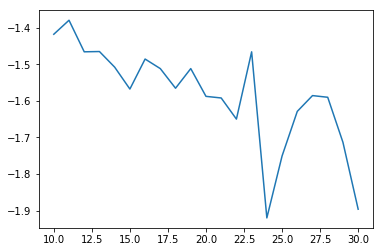

In [ ]:
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.models import LdaModel
# import seaborn as sns
# from tqdm import tqdm

# temp = dictionary[0] # to 'load' dictionary
# id2word = dictionary.id2token

# # parameters
# feature = 'body_bow' # lda uses bow
# corpus = df_2017[feature].values

# results = []

# for i in tqdm(range(10,31)):
#   model = LdaModel(
#     corpus = corpus,
#     id2word = id2word,
#     chunksize = 2000,
#     alpha = 'auto',
#     eta = 'auto',
#     iterations = 400,
#     num_topics = i,
#     passes = 20,
#     eval_every = None
#     )
#   cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
#   coherence = cm.get_coherence()
#   results.append([i,coherence])
  
# best_score = max([i[1] for i in results])
# best_num_topics = [i[0] for i in results if i[1] == best_score][0]
# sns.lineplot(x=[i[0] for i in results], y=[i[1] for i in results])
# print('Best Coherence Score: {}, Number of Topics: {}'.format(best_score, best_num_topics))

## LDA

In [25]:
from gensim.models import LdaModel

temp = dictionary[0] # to 'load' dictionary
id2word = dictionary.id2token

# parameters
feature = 'body_bow' # lda uses bow
corpus = df_2017[feature].values
# num_topics = best_num_topics
num_topics = 11

model_2017 = LdaModel(
  corpus = corpus,
  id2word = id2word,
  chunksize = 2000,
  alpha = 'auto',
  eta = 'auto',
  iterations = 400,
  num_topics = num_topics,
  passes = 20,
  eval_every = None
  )

### LDA Visualisation

In [26]:
import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model_2017, corpus, dictionary)

# The larger the bubble, the more prevalent is that topic.
# A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
# A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.018670  0.215786       1        1  17.183453
2      0.169207  0.026692       2        1  13.253837
6      0.040707  0.199367       3        1  10.858539
9     -0.093987  0.155466       4        1  10.515118
5     -0.008059 -0.049384       5        1  10.089892
0     -0.101791  0.011254       6        1   8.687329
8      0.211107 -0.118468       7        1   7.618022
7     -0.134868 -0.180823       8        1   7.001425
1      0.217514 -0.082662       9        1   6.905531
4     -0.067811 -0.085567      10        1   5.766517
10    -0.213350 -0.091661      11        1   2.120335, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
329    Default  29046.000000          north  29046.000000  30.0000  30.0000
740    Default  11076.000000          party  11076.000000  29.0000  29.0000
341    Default  10055.000000           park  10055.000000  28.0000  28.0000
321    Default   9551.000000           moon   9551.000000  27.0000  27.0000
113    Default   6558.000000        percent   6558.000000  26.0000  26.0000
317    Default   9850.000000        missile   9850.000000  25.0000  25.0000
354    Default  13467.000000      president  13467.000000  24.0000  24.0000
332    Default   8827.000000        nuclear   8827.000000  23.0000  23.0000
451    Default   4172.000000          court   4172.000000  22.0000  22.0000
718    Default   5846.000000       military   5846.000000  21.0000  21.0000
358    Default   5910.000000   presidential   5910.000000  20.0000  20.0000
255    Default   3422.000000       election   3422.000000  19.0000  19.0000
24     Default   5767.000000          china   5767.000000  18.0000  18.0000
237    Default   5268.000000        defense   5268.000000  17.0000  17.0000
100    Default   7029.000000       ministry   7029.000000  16.0000  16.0000
207    Default   3120.000000           choi   3120.000000  15.0000  15.0000
894    Default   8339.000000     government   8339.000000  14.0000  14.0000
418    Default   4931.000000          trump   4931.000000  13.0000  13.0000
365    Default   4787.000000      pyongyang   4787.000000  12.0000  12.0000
438    Default   2889.000000            ahn   2889.000000  11.0000  11.0000
889    Default   5345.000000         former   5345.000000  10.0000  10.0000
3910   Default   2067.000000      candidate   2067.000000   9.0000   9.0000
911    Default   9379.000000            kim   9379.000000   8.0000   8.0000
406    Default   4666.000000           test   4666.000000   7.0000   7.0000
719    Default   5365.000000       minister   5365.000000   6.0000   6.0000
223    Default   2313.000000   conservative   2313.000000   5.0000   5.0000
30     Default   9085.000000        country   9085.000000   4.0000   4.0000
407    Default   2293.000000          thaad   2293.000000   3.0000   3.0000
2967   Default   2397.000000         police   2397.000000   2.0000   2.0000
44     Default   4478.000000        foreign   4478.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
11380  Topic11     70.520531  low_birthrate     71.412933   3.8410  -6.4507
14577  Topic11     69.708641            cow     70.600967   3.8409  -6.4623
3051   Topic11    199.105560       outbreak    212.348923   3.7892  -5.4128
5667   Topic11     77.158455           fish     79.180779   3.8277  -6.3608
2017   Topic11    198.813599        refugee    243.486053   3.6509  -5.4143
7990   Topic11    316.063934        holiday    436.700623   3.5303  -4.9507
5024   Topic11    190.978409          mokpo    241.720276   3.6180  -5.4545
2335   Topic11    257.684387        disease    386.818604   3.4474  -5.1549
346    Topic11    123.244377         pohang    145.484161   3.6877  -5.8925
1967   Topic11    368.507843           food    701.994995   3.2

In [134]:
topics_2017 = pd.DataFrame({'topic':[i for i in range(11)]})
topics_2017['keywords'] = topics_2017.topic.apply(lambda x: sorted(model_2017.show_topic(x, 20),key=lambda x: x[1], reverse=True))
topics_2017.to_pickle('topics_2017.pkl')
topics_2017

,topic,keywords
0,0,"[(country, 0.013492537), (government, 0.011691542), (million, 0.0060922587), (ministry, 0.0060153557), (company, 0.005700396), (economic, 0.0056396783), (development, 0.005175794), (billion, 0.0049887993), (business, 0.0049694413), (job, 0.0049242247), (people, 0.004468432), (industry, 0.004433722), (project, 0.004368086), (trade, 0.004318309), (new, 0.004292581), (economy, 0.004251617), (percent, 0.0041964683), (plan, 0.004006122), (policy, 0.0039444854), (according, 0.003765744)]"
1,1,"[(party, 0.060815036), (election, 0.020086182), (moon, 0.01997968), (presidential, 0.017697949), (ahn, 0.015123981), (candidate, 0.014214468), (conservative, 0.013175356), (percent, 0.012993014), (democratic, 0.010343442), (people, 0.008838045), (rep, 0.0086878), (former, 0.008669872), (hong, 0.008573867), (liberal, 0.0074073677), (democratic_party, 0.0073403553), (park, 0.007096866), (jae, 0.006860536), (liberty, 0.0067197164), (moon_jae, 0.006379668), (presidential_election, 0.0062101376)]"
2,2,"[(president, 0.019397713), (moon, 0.011974599), (government, 0.009762684), (national, 0.009180083), (minister, 0.0080284495), (party, 0.006799339), (kim, 0.0066717225), (new, 0.0063268268), (presidential, 0.0061500156), (hwang, 0.0059534153), (office, 0.0057461616), (chief, 0.0056940056), (public, 0.005677788), (assembly, 0.005366015), (opposition, 0.0053019337), (jae, 0.0051304637), (committee, 0.0049633645), (ruling, 0.004845976), (meeting, 0.004784163), (park, 0.004670893)]"
3,3,"[(north, 0.057687785), (nuclear, 0.02005786), (missile, 0.011265991), (trump, 0.01101204), (pyongyang, 0.010961482), (state, 0.009389606), (sanction, 0.0073693055), (test, 0.007184028), (china, 0.0063643646), (kim, 0.0062358715), (security, 0.0059556575), (would, 0.0059279953), (president, 0.0056265076), (washington, 0.005545918), (weapon, 0.005520036), (regime, 0.005345202), (snited, 0.0049655), (leader, 0.0048276572), (threat, 0.0045454134), (jong, 0.0044547087)]"
4,4,"[(school, 0.011702637), (student, 0.010164392), (herald, 0.008672867), (korea_herald, 0.008148213), (education, 0.007719121), (one, 0.0067564314), (sniversity, 0.0065506627), (people, 0.0064404183), (lee, 0.0061425692), (city, 0.0060352264), (event, 0.0058294297), (com, 0.004880828), (many, 0.0048622256), (kim, 0.004815338), (like, 0.004786712), (heraldcorp, 0.0046981713), (world, 0.0045703007), (time, 0.0044722133), (professor, 0.004293139), (first, 0.004289655)]"
5,5,"[(kim, 0.016871689), (police, 0.010489742), (woman, 0.01002102), (right, 0.0070316317), (japan, 0.0058765407), (jong, 0.0057707992), (victim, 0.005556973), (human, 0.005321672), (two, 0.0049833623), (government, 0.004786967), (human_right, 0.004725091), (official, 0.004713701), (group, 0.004621889), (ministry, 0.004509452), (nam, 0.0042902273), (kim_jong, 0.00415639), (case, 0.004047913), (japanese, 0.0038709107), (country, 0.0037902035), (man, 0.0037467293)]"
6,6,"[(china, 0.014433945), (moon, 0.014149873), (president, 0.0124848755), (foreign, 0.011363909), (south_korean, 0.011142642), (minister, 0.010940351), (meeting, 0.01020472), (issue, 0.010162189), (country, 0.01000089), (two, 0.009888488), (thaad, 0.009857864), (defense, 0.008866342), (ministry, 0.007755677), (deployment, 0.0072838096), (visit, 0.0069057597), (summit, 0.006595967), (talk, 0.006566679), (chinese, 0.006525237), (japan, 0.0060279663), (system, 0.005983284)]"
7,7,"[(percent, 0.026453106), (number, 0.008895621), (according, 0.007458843), (people, 0.007043669), (province, 0.0066686245), (showed, 0.00623886), (last, 0.006009414), (day, 0.005498189), (ferry, 0.0051206877), (time, 0.00509986), (survey, 0.0050598183), (ship, 0.004891122), (com, 0.0047413055), (hour, 0.004696809), (heraldcorp, 0.0046857954), (percentage, 0.0046072495), (city, 0.004489808), (sewol, 0.0044523557), (high, 0.0043727877), (month, 0.004344675)]"
8,8,"[(park, 0.043223247), (court, 0.02186442), (choi, 0.017638922), (president, 0.015936403), (former, 0.012834001), (lee, 0.01092335

### Assign Topics to Docs

In [27]:
def argmax(ls):
  return max(ls, key = lambda item: item[1])


df_2017['topic'] = df_2017[feature].apply(lambda x : argmax(model_2017.get_document_topics(x))[0])
df_2017['topic_confidence'] = df_2017[feature].apply(lambda x : argmax(model_2017.get_document_topics(x))[1])

## Cluster Analysis

### get only documents with topic_confidence >= t = 0.85

In [95]:
df_2017 = pd.read_pkl('df_2017.pkl')

In [96]:
df_anal = df_2017[df_2017['topic_confidence'] >= 0.85]

## Metric 1: Number of Documents

In [97]:
df_anal.topic.value_counts()

3     167
9      73
7      59
6      55
8      49
2      44
10     22
5      16
1      11
4       1
0       1
Name: topic, dtype: int64

## Metric 2: Duration of Reporting

In [89]:
from datetime import datetime

report_duration = pd.DataFrame(columns=['topic','duration'])

for i in df_anal.topic.unique():
  df = df_anal[df_anal['topic'] == i]
  max_t = datetime.strptime(df.time.max(), "%Y-%m-%d %H:%M:%S").date()
  min_t = datetime.strptime(df.time.min(), "%Y-%m-%d %H:%M:%S").date()
  report_duration = report_duration.append(pd.DataFrame({'topic': i, 'duration': (max_t - min_t)}, index=[i]))
  
report_duration.sort_values('duration',ascending=False)

,topic,duration
3,3,348 days
8,8,346 days
9,9,342 days
10,10,328 days
5,5,306 days
1,1,303 days
7,7,298 days
2,2,276 days
6,6,246 days
4,4,0 days


## Metric 3: Entity Relations

In [91]:
import spacy
nlp = spacy.load("en")

# Labels: ORG, LOC, PERSON
def get_entities(txt, label):
  #the NER model only takes in unicode so convert str to unicode
  doc = nlp(txt)
  
  #doc now contains all the entities identified
  NER_list = [((ent.text).encode("utf-8"),ent.label_) for ent in doc.ents]

  #this line is to remove duplicate entities
  NER_list = list(dict.fromkeys(NER_list))

  #converting list of tuples to list of lists for easier manipulation later
  NER_list_final = [list(entity) for entity in NER_list]

  #Filtering for the entity labels that we are interested in.
  entities = [entity[0] for entity in NER_list_final if entity[1] == label]
  
  return entities

df_anal['ORGS'] = df_anal['body'].apply(lambda x: get_entities(x, 'ORG'))
df_anal['LOC'] = df_anal['body'].apply(lambda x: get_entities(x, 'LOC'))
df_anal['PERSON'] = df_anal['body'].apply(lambda x: get_entities(x, 'PERSON'))

/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Cellar/ipython/7.4.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [92]:
entity_counts = pd.DataFrame(columns=['topic','n_org','n_loc','n_person'])

for i in df_anal.topic.unique():
  df = df_anal[df_anal['topic'] == i]
  n_orgs = len(set([x for ls in df['ORGS'] for x in ls]))
  n_loc = len(set([x for ls in df['LOC'] for x in ls]))        
  n_person = len(set([x for ls in df['PERSON'] for x in ls]))
  entity_counts = entity_counts.append(pd.DataFrame({'topic': i,'n_org': n_orgs,'n_loc': n_loc,'n_person': n_person,'n_total': n_orgs + n_loc + n_person}, index=[i]))
  
entity_counts.sort_values('n_total',ascending=False)

,n_loc,n_org,n_person,n_total,topic
3,20,22,38,80.0,3
9,17,11,22,50.0,9
2,11,10,18,39.0,2
8,8,7,12,27.0,8
6,7,6,11,24.0,6
7,3,4,10,17.0,7
5,7,0,6,13.0,5
1,4,1,4,9.0,1
10,2,3,2,7.0,10
4,1,1,0,2.0,4


In [128]:
results_2017 = pd.DataFrame()
results_2017['topic'] = df_anal.topic.value_counts().index
results_2017['doc_counts'] = df_anal.topic.value_counts().values
results_2017 = pd.merge(results_2017.astype('object'), report_duration.astype('object'), on='topic')
results_2017 = pd.merge(results_2017, entity_counts, on='topic')

results_2017

,topic,doc_counts,duration,n_loc,n_org,n_person,n_total
0,3,167,348 days 00:00:00,20,22,38,80.0
1,9,73,342 days 00:00:00,17,11,22,50.0
2,7,59,298 days 00:00:00,3,4,10,17.0
3,6,55,246 days 00:00:00,7,6,11,24.0
4,8,49,346 days 00:00:00,8,7,12,27.0
5,2,44,276 days 00:00:00,11,10,18,39.0
6,10,22,328 days 00:00:00,2,3,2,7.0
7,5,16,306 days 00:00:00,7,0,6,13.0
8,1,11,303 days 00:00:00,4,1,4,9.0
9,4,1,0 days 00:00:00,1,1,0,2.0


In [118]:
# topic ranking for 2017
topic_ids_2017 = [3, 9, 7, 6, 8, 2, 10, 5, 1, 4]

topics_2017 = pd.DataFrame({'topic':[i for i in topic_ids_2017]})
topics_2017['keywords_prob'] = topics_2017.topic.apply(lambda x: sorted(model_2017.show_topic(x, 20),key=lambda x: x[1], reverse=True))
topics_2017['keywords'] = topics_2017['keywords_prob'].apply(lambda x: [i[0] for i in x])


# topics_2017.to_pickle('selected_topics_2017.pkl',index=False)

topics_2017[['topic','keywords']]

,topic,keywords
0,3,"[north, nuclear, missile, trump, pyongyang, state, sanction, test, china, kim, security, would, president, washington, weapon, regime, snited, leader, threat, jong]"
1,9,"[north, missile, military, defense, test, force, ministry, official, launch, south_korean, ballistic, range, joint, air, exercise, system, two, ballistic_missile, nuclear, pyongyang]"
2,7,"[percent, number, according, people, province, showed, last, day, ferry, time, survey, ship, com, hour, heraldcorp, percentage, city, sewol, high, month]"
3,6,"[china, moon, president, foreign, south_korean, minister, meeting, issue, country, two, thaad, defense, ministry, deployment, visit, summit, talk, chinese, japan, system]"
4,8,"[park, court, choi, president, former, lee, prosecutor, scandal, geun, hye, impeachment, office, presidential, charge, president_park, trial, samsung, prosecution, investigation, allegation]"
5,2,"[president, moon, government, national, minister, party, kim, new, presidential, hwang, office, chief, public, assembly, opposition, jae, committee, ruling, meeting, park]"
6,10,"[hwang_kyo, ministry, government, country, food, animal, safety, farm, holiday, dog, case, official, disease, measure, inspection, authority, egg, virus, agency, province]"
7,5,"[kim, police, woman, right, japan, jong, victim, human, two, government, human_right, official, group, ministry, nam, kim_jong, case, japanese, country, man]"
8,1,"[party, election, moon, presidential, ahn, candidate, conservative, percent, democratic, people, rep, former, hong, liberal, democratic_party, park, jae, liberty, moon_jae, presidential_election]"
9,4,"[school, student, herald, korea_herald, education, one, sniversity, people, lee, city, event, com, many, kim, like, heraldcorp, world, time, professor, first]"


# Save DataFrames as PKL

In [33]:
df_2015.to_pickle('df_2015.pkl',index=False)
df_2016.to_pickle('df_2016.pkl',index=False)
df_2017.to_pickle('df_2017.pkl',index=False)

# Analysis of Keywords for Ranked Topics

In [142]:
topics_2015[['topic','keywords']]

,topic,keywords
0,3,"[mers, patient, disease, health, hospital, medical, case, ministry, people, virus, outbreak, country, first, day, confirmed, middle, respiratory, reported, may, middle_east]"
1,4,"[percent, child, number, worker, according, woman, last, job, rate, last_year, showed, million, labor, government, report, time, data, wage, people, work]"
2,6,"[north, nuclear, china, missile, pyongyang, state, security, would, test, washington, issue, snited, right, threat, party, could, international, talk, long, snited_state]"
3,7,"[country, world, development, trade, government, company, city, project, international, economic, new, business, billion, market, people, economy, global, energy, industry, million]"
4,8,"[japan, japanese, abe, issue, tokyo, war, woman, history, world, minister, victim, wartime, statement, sexual, apology, relation, prime, country, historical, world_war]"
5,0,"[party, park, lee, president, kim, former, sung, opposition, election, minister, presidential, moon, saenuri, political, new, rep, ruling, lawmaker, prime, president_park]"
6,11,"[north, kim, pyongyang, inter, two, south_korean, border, inter_korean, official, jong, leader, war, government, leader_kim, military, family, talk, ministry, day, unification]"
7,1,"[park, meeting, china, president, foreign, minister, two, talk, visit, cooperation, official, summit, south_korean, bilateral, president_park, country, hye, geun, geun_hye, ministry]"
8,10,"[school, student, education, court, government, law, ministry, right, case, textbook, one, state, kim, high, would, history, university, sniversity, official, teacher]"
9,5,"[defense, military, force, official, ministry, air, missile, south_korean, submarine, joint, navy, two, troop, sea, operation, plan, army, exercise, country, defense_ministry]"


In [108]:
topics_2016[['topic','keywords']]

,topic,keywords
0,6,"[north, missile, nuclear, test, defense, launch, military, security, china, range, thaad, threat, system, ballistic, rocket, council, pyongyang, state, ballistic_missile, official]"
1,8,"[party, saenuri, opposition, election, rep, kim, park, minjoo, lawmaker, ruling, minjoo_party, political, leader, people, former, president, candidate, lee, saenuri_party, member]"
2,5,"[percent, number, government, million, ministry, according, worker, health, last, showed, company, report, last_year, job, medical, data, people, total, among, average]"
3,7,"[north, nuclear, sanction, pyongyang, kim, china, country, test, state, leader, jong, regime, weapon, official, international, resolution, long, source, report, may]"
4,2,"[country, economic, international, cooperation, foreign, world, two, development, trade, minister, new, government, last, economy, business, nation, program, effort, global, project]"
5,3,"[park, president, choi, president_park, presidential, geun, hye, office, geun_hye, scandal, dae, cheong, minister, state, cheong_dae, official, former, affair, soon, hwang]"
6,1,"[japan, military, japanese, victim, south_korean, war, woman, two, government, ministry, deal, chinese, tokyo, soldier, issue, official, country, sexual, agreement, island]"
7,11,"[city, ministry, government, air, province, official, country, area, system, safety, airport, plan, site, virus, passenger, vehicle, meter, kilometer, resident, according]"
8,4,"[school, student, child, education, woman, one, kim, old, lee, time, year_old, family, parent, com, heraldcorp, many, would, day, life, young]"
9,10,"[court, group, rally, law, park, government, right, impeachment, public, people, protest, legal, civic, labor, central, ock, saturday, constitutional, held, decision]"


In [109]:
topics_2017[['topic','keywords']]

,topic,keywords
0,3,"[north, nuclear, missile, trump, pyongyang, state, sanction, test, china, kim, security, would, president, washington, weapon, regime, snited, leader, threat, jong]"
1,9,"[north, missile, military, defense, test, force, ministry, official, launch, south_korean, ballistic, range, joint, air, exercise, system, two, ballistic_missile, nuclear, pyongyang]"
2,7,"[percent, number, according, people, province, showed, last, day, ferry, time, survey, ship, com, hour, heraldcorp, percentage, city, sewol, high, month]"
3,6,"[china, moon, president, foreign, south_korean, minister, meeting, issue, country, two, thaad, defense, ministry, deployment, visit, summit, talk, chinese, japan, system]"
4,8,"[park, court, choi, president, former, lee, prosecutor, scandal, geun, hye, impeachment, office, presidential, charge, president_park, trial, samsung, prosecution, investigation, allegation]"
5,2,"[president, moon, government, national, minister, party, kim, new, presidential, hwang, office, chief, public, assembly, opposition, jae, committee, ruling, meeting, park]"
6,10,"[hwang_kyo, ministry, government, country, food, animal, safety, farm, holiday, dog, case, official, disease, measure, inspection, authority, egg, virus, agency, province]"
7,5,"[kim, police, woman, right, japan, jong, victim, human, two, government, human_right, official, group, ministry, nam, kim_jong, case, japanese, country, man]"
8,1,"[party, election, moon, presidential, ahn, candidate, conservative, percent, democratic, people, rep, former, hong, liberal, democratic_party, park, jae, liberty, moon_jae, presidential_election]"
9,4,"[school, student, herald, korea_herald, education, one, sniversity, people, lee, city, event, com, many, kim, like, heraldcorp, world, time, professor, first]"
